In [1]:
import random
import glob
from importlib import reload
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import seaborn as sn
import time
import frame_loader as frame_loader
import utils as utils
import augmentation as augmentation
import graph_neural_network
from typing import  List

import numpy as np
import math
import pandas as pd
from pandas import DataFrame
from scipy.spatial import distance as distance_calculator
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler
import frame_loader as frame_loader

#### Hyperparameters

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reduced_cols = ['doppler','snr','x','y','current_frame','Label']
column_names=['range','azimuth','doppler','snr','x','y','current_frame','seq', 'Label']
selected_cols = ['doppler','snr','x','y']
SHAPE_NAMES = [0,1,2,3,4, 5]
frame_depths = [5] 
ks = [4]
num_chunks = 16
lr = 0.001
max_epoch = 50
size = 64
split = 64
EARLY_STOPPING_PATIENCE = 10
# train, val, test =[],[],[]

#### Pre-processing pipeline

In [3]:
reload(frame_loader)
reload(utils)
# Load equal frames
# try:
#     point_frames = pd.read_csv(f"data/frames_{size}points_all_varied_fixed.csv", names=column_names, header=None, dtype=np.float64)
#     print("File read")
# except Exception as e:
#     point_frames = frame_loader.equal_frame_loader(column_names,size)
#     print("Frames generated")

try:
    point_frames = pd.read_csv("data/all_data.csv", names=column_names, header=None, dtype=np.float64)
    print("File read")
except Exception as e:
    point_frames = frame_loader.load_original_frames()
    print("Frames generated")

# Normalize the data
# norm_frames = utils.min_max_normalization(point_frames, selected_cols)

# group the data by frame numbers
all_data_grouped = point_frames[reduced_cols].groupby("current_frame")
print("Total number of frames: "+str(len(all_data_grouped)))
data_array = [frame.to_numpy() for (_, frame) in all_data_grouped]

# Sort the data
sorted_data = sorted(data_array,key=lambda x:x[:,4].max(axis=0))
# xy_sorted = [sorted(x,key=lambda x:[x[3], x[2]]) for x in sorted_data]
# xy_dist = [x[:,2]+x[:,3] for x in sorted_data]
# xy_sort_index = [d.argsort() for d in xy_dist]
# xy_sorted = np.array([frame[xy_sort_index[i]] for i, frame in enumerate(sorted_data)])

# Split the data
train, val, test = utils.split_with_chunks_list(sorted_data, SHAPE_NAMES, num_chunks, 0.15, 0.15)


File read
Total number of frames: 23442


In [8]:
print(test)
print(test.shape)
print(val.shape)

[[[1.18110236e-02 4.92674705e-03 7.88814770e-01 2.70461587e-01
   9.51890000e+04 0.00000000e+00]
  [1.18110236e-02 4.92674705e-03 7.88814770e-01 2.70461587e-01
   9.51890000e+04 0.00000000e+00]
  [1.18110236e-02 3.75988591e-03 7.57780428e-01 2.75903185e-01
   9.51890000e+04 0.00000000e+00]
  ...
  [3.14960630e-02 3.11162972e-03 8.12956556e-01 3.53035613e-01
   9.51890000e+04 0.00000000e+00]
  [3.14960630e-02 3.11162972e-03 8.12956556e-01 3.53035613e-01
   9.51890000e+04 0.00000000e+00]
  [3.14960630e-02 3.11162972e-03 8.12956556e-01 3.53035613e-01
   9.51890000e+04 0.00000000e+00]]

 [[2.36220472e-02 2.72267600e-03 8.00942266e-01 2.41723184e-01
   9.51910000e+04 0.00000000e+00]
  [1.96850394e-02 2.85232724e-03 7.88621543e-01 2.48413821e-01
   9.51910000e+04 0.00000000e+00]
  [1.96850394e-02 2.85232724e-03 7.88621543e-01 2.48413821e-01
   9.51910000e+04 0.00000000e+00]
  ...
  [6.29921260e-02 3.24128095e-03 8.42177423e-01 3.20353030e-01
   9.51910000e+04 0.00000000e+00]
  [6.29921260e-0

In [10]:
test_val = np.append(test, val, axis=0)
print(test_val.shape)

(6412, 256, 6)


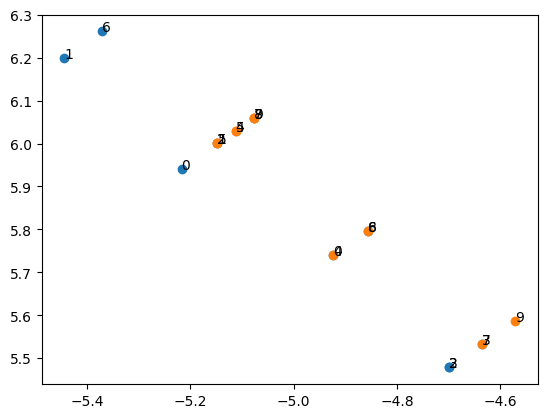

In [62]:
a = train[5][:, 2:4]
b = train[6][:, 2:4]
# _, idx = np.unique(a,axis=0, return_index=True)
# a=a[np.sort(idx)]
# _, idx = np.unique(b,axis=0, return_index=True)
# b=b[np.sort(idx)]
p = 10
n = np.arange(size)
fig, ax = plt.subplots()
ax.scatter(a[:p, 1], a[:p, 0])
ax.scatter(b[:p, 1], b[:p, 0])
for i, txt in enumerate(n[:p]):
    ax.annotate(txt, (a[:p, 1][i], a[:p, 0][i]))
    ax.annotate(txt, (b[:p, 1][i], b[:p, 0][i]))



In [23]:
print(math.ceil(4/2))

2


In [11]:
reload(utils)

def connect_frames(current_frame:List[np.array], next_frame:List[np.array], k: int, start_index: int, mode:str="desc"):
    """
    Calculates the edges between two frames. 
    
    :param current_frame: The current frame containing parameters to calculate the distance based on 
    :param next_frame: The previous frame containing parameters to calculate the distance based on 
    :param k: The number of neighbours to have in the graph
    :param start_index: The index to start labeling the nodes from
    :param descending: Indicates whether to connect nearest neighbours or furthest neighbours
    :return: The values (euclidean distance between points) of the edges and an adjacency list containing the nodes that are connected in the graph. 
            It also returns a boolean indicating whether the creation was successful or not.
    """
    if mode == "one_to_one":
        current_nodes = np.arange(start_index, start_index+len(current_frame)) 
        next_nodes = np.arange(start_index+len(current_frame), start_index+len(current_frame)+len(next_frame))
        edges = [math.dist(curr,next_frame[min(len(next_frame)-(k-i),max(i,curr_index-(math.ceil(k/2)-1)+i))]) for curr_index, curr in enumerate(current_frame) for i in range(k)]
        # edges = [math.dist(p,q) for p,q in zip(current_frame, next_frame)]
        adjacency_list = [(curr,next_nodes[min(len(next_frame)-(k-i),max(i,curr_index-(math.ceil(k/2)-1)+i))]) for curr_index, curr in enumerate(current_nodes) for i in range(k)]
        # adjacency_list = [(p,q) for p,q in zip(current_nodes, next_nodes)]
        return edges, adjacency_list, True
    edges = []
    adjacency_list = []
    current_nodes = np.arange(start_index, start_index+len(current_frame)) 
    next_nodes = np.arange(start_index+len(current_frame), start_index+len(current_frame)+len(next_frame))
    distances_all  = distance_calculator.cdist(current_frame, next_frame, 'euclidean')
    for i in range(len(current_frame)):
        distances = distances_all[i]
        if mode == "desc":
            idx = distances.argsort()[::-1]
        elif mode == "asc":
            idx = distances.argsort()
        else:
            raise Exception("No such mode")
        distances = distances[idx]
        ordered_next_nodes = next_nodes[idx]
        if len(distances) < k:
            return [], [], False
        
        edges.extend(distances[:k])
        for j in range(k):
            adjacency_list.append((current_nodes[i], ordered_next_nodes[j]))
    return edges, adjacency_list, True

def create_graph_list_with_overlap(frames:np.array, selected_cols:List[str], device:str, size:int, split:int,
                                   k:int = 3, frame_depth:int = 2, mode:str="desc"):
    """
    Creates a list of Data objects that represents the graphs built from the input data. 
    The edges in the graph connects the frames to the previous frame by connecting each 
    points in a frame to it's nearest/furthest neighbour in the previous frame. 
    The nodes contain information about the selected columns. 
    The edges store information about the eucledian distance between the points.
    
    :param frames: Input data grouped and sorted by the frame number
    :param device: The device to store the graphs on (cuda or cpu)
    :param selected_cols: The names of the columns to make nodes out of
    :param k: The number of neighbours to connect each points to
    :param frame_depth: The depth of the graph (number of previos nodes)
    :param descending: Indicates whether to connect nearest neighbours or furthest neighbours
    :return: A list of Data objects, containing information about the created graphs
    """
    parts = int(size/split)
    if len(frames) == 0:
        return []
    graphs = []
    for i, frame in enumerate(frames[frame_depth:]):
        nodes = []
        edges = []
        adjacency_list = []
        relevant_frames = frames[i: i + frame_depth + 1]
        point_data = relevant_frames[:,:,0:4]

        # further split frames into more frames
        point_data_array = np.array([[f[int((p*size)/parts):int(((p+1)*size)/parts)] for p in range(parts)] for f in point_data])
        point_data_array = point_data_array.reshape((frame_depth+1)*parts,-1,len(selected_cols))

        # only make graphs if the gap between any two frames is at most 9 and all frames have the same label
        frame_diff = [relevant_frames[i+1,0, 4] - relevant_frames[i,0, 4] for i in range(frame_depth)]
        if max(frame_diff) > 9 or relevant_frames[-1,0, 5] != relevant_frames[0,0, 5]:
            continue

        # point_data_array = [df.to_numpy() for df in point_data]
        start_index = 0
        new_depth = len(point_data_array)-1
        for depth in range(new_depth):
            #calculate the distance for the edges based on the x and y coordinates
            pairwise_edges, pairwise_adjacency_list, success = \
                connect_frames(point_data_array[new_depth-depth][:,2:4], point_data_array[new_depth-depth-1][:,2:4], k, start_index, mode)
            if not success:
                break
            start_index += len(point_data_array[new_depth-depth])
            edges.extend(pairwise_edges)
            adjacency_list.extend(pairwise_adjacency_list)
            nodes.extend(point_data_array[new_depth-depth])
        if not success:
                continue
        nodes.extend(point_data_array[0])
        label = frame[0,5]
        data = Data(x=torch.tensor(np.array(nodes), dtype=torch.float32, device=device),
                    edge_index=torch.tensor(np.array(adjacency_list), dtype=torch.int64, device=device).t().contiguous(),
                    edge_attr=torch.tensor(np.array(edges), dtype=torch.float32, device=device),
                    y=torch.tensor(int(label), dtype=torch.int64, device=device))
        
        graphs.append(data)
    return graphs


def load_graphs(train:List[DataFrame], val:List[DataFrame], test:List[DataFrame], 
                frame_depths:List[int], ks:List[int], selected_cols:List[str], num_chunks:int, size:int, split:int, device:str, mode:str="desc"):
    """
    Loads the graphs if already saved or creates them if not yet saved.

    :param train: The frames in the train set
    :param val: The frames in the validation set
    :param test: The frames in the test set
    :param frame_depths: The depths of the graph (number of previos nodes)
    :param ks: The number of neighbours to connect each points to
    :param selected_cols: The names of the columns to make nodes out of
    :param device: The device to store the graphs on (cuda or cpu)
    :param descending: Indicates whether to connect nearest neighbours or furthest neighbours
    :return: The graphs created from the train, validation and test sets
    """
    graph_sets = []
    for i, data_set in enumerate([train, val, test]):
        generated_graphs = []
        for f in frame_depths:
            for k in ks:
                # try:
                #     graphs = torch.load(f"data/frame_graphs_k{k}_frame_depth{f}_normalized_extended_chunk{num_chunks}_type{i}_size{size}_split{split}.pt")
                #     print("File read")
                # except Exception as e:
                graphs = create_graph_list_with_overlap(data_set, selected_cols, device, size=size, split=split, k=k, frame_depth=f, mode=mode)
                    # torch.save(graphs, f"data/frame_graphs_k{k}_frame_depth{f}_normalized_extended_chunk{num_chunks}_type{i}_size{size}_split{split}.pt")
                
                print(f"Number of graphs generated with k = {k} and frame depth = {f} for type {i}: {len(graphs)}")
                generated_graphs.append(graphs)
        graph_sets.append(generated_graphs)
    
    return graph_sets[0], graph_sets[1], graph_sets[2]

# Create graphs for each sets with each hyperparameter combination
train_graphs, val_graphs, test_graphs = load_graphs(train, [], test_val, frame_depths, ks, selected_cols, \
                                                          num_chunks, size, split, device, mode="desc")

Number of graphs generated with k = 6 and frame depth = 8 for type 0: 6988
Number of graphs generated with k = 6 and frame depth = 8 for type 1: 0
Number of graphs generated with k = 6 and frame depth = 8 for type 2: 2487


In [4]:
reload(utils)

# Create graphs for each sets with each hyperparameter combination
train_graphs, val_graphs, test_graphs = utils.load_graphs(train, val, test, frame_depths, ks, selected_cols, \
                                                          num_chunks, size, split, device, mode="random")

Number of graphs generated with k = 4 and frame depth = 5 for type 0: 10092
Number of graphs generated with k = 4 and frame depth = 5 for type 1: 1958
Number of graphs generated with k = 4 and frame depth = 5 for type 2: 1957


#### Data augmentation

In [5]:
reload(augmentation)
    
# augment with random graphs
augmentation_transformer = augmentation.AugmentationTransformerList(size)
# four_graph_loc = np.array([data.y.cpu() == 3 for data in train_graphs[0]])
# four_index = np.where(four_graph_loc)[0].tolist()
# four_graphs = [train_graphs[0][i] for i in four_index]

# bike_graph_loc = np.array([data.y.cpu() == 5 for data in train_graphs[0]])
# bike_index = np.where(bike_graph_loc)[0].tolist()
# bike_graphs = [train_graphs[0][i] for i in bike_index]

# indexes = np.arange(len(train_graphs[0])).tolist()
# random.seed(42)
# sample_train = random.sample(indexes, 1000)
# sample_train = [train_graphs[0][i] for i in sample_train]

augmented_graphs = augmentation_transformer(train_graphs[0])
train_graphs[0].extend(augmented_graphs)

# # augment with random graphs from 4 people
# indexes = np.arange(len(four_graphs)).tolist()
# random.seed(42)
# sample_four = random.sample(indexes, 500)
# sample_four = [four_graphs[i] for i in sample_four]

# augmented_four = augmentation_transformer(sample_four)
# train_graphs[0].extend(augmented_four)

# # augment with random graphs from bikes
# indexes = np.arange(len(bike_graphs)).tolist()
# random.seed(42)
# sample_bike = random.sample(indexes, 100)
# sample_bike = [bike_graphs[i] for i in sample_bike]

# augmented_bike = augmentation_transformer(sample_bike)
# train_graphs[0].extend(augmented_bike)


In [6]:
train_dataloaders = []
test_dataloaders = []
val_dataloaders = []

# Batch the sets
for i in range(len(train_graphs)):
    random.seed(42)
    random.shuffle(train_graphs[i])
    random.seed(42)
    random.shuffle(test_graphs[i])
    random.seed(42)
    random.shuffle(val_graphs[i])
    
    train_dataloaders.append(DataLoader(train_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
    test_dataloaders.append(DataLoader(test_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
    val_dataloaders.append(DataLoader(val_graphs[i], batch_size=32, shuffle=True, num_workers = 0))


#### Train the model

trained: 0


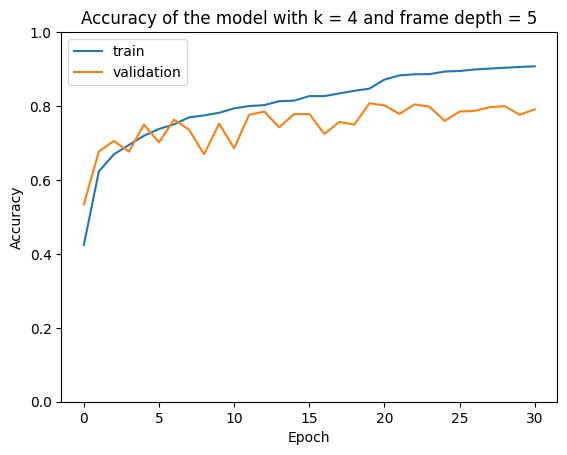

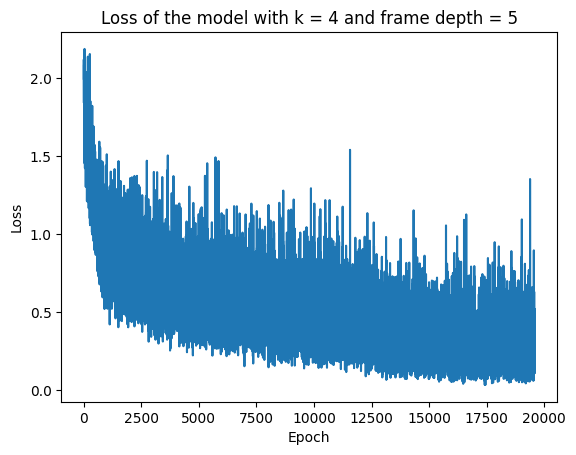

Training accuracy: 0.9075505350772889
Training loss: 0.11551816
Accuracy of the model with k = 4 and frame depth = 5: 0.7911
--- 726.3853468894958 seconds ---
evaluated: 0


In [15]:
reload(graph_neural_network)
models = []

for i, train_dataloader in enumerate(train_dataloaders):
    val_accuracies = []
    start_time = time.time()
    k = ks[i % len(ks)]
    model = graph_neural_network.Net(6, k=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    best_acc = -1
    losses = []
    accuracies = []
    for epoch in range(max_epoch):
        correct = 0
        count = 0
        model.train()
        for train_batch in train_dataloader:
            train_batch = train_batch.to(device)
            optimizer.zero_grad()
            out = model(train_batch)
            pred = out.argmax(dim=1)
            correct += (pred == train_batch.y).sum()
            loss = F.nll_loss(out, train_batch.y)
            losses.append(loss.detach())
            loss.backward()
            optimizer.step()
            count += len(train_batch)
        acc = int(correct) / count
        losses.append(loss.detach())
        accuracies.append(acc)
        scheduler.step()

        model.eval()
        val_correct = 0
        for val_batch in val_dataloaders[i]:
            val_batch = val_batch.to(device)
            pred = model(val_batch).argmax(dim=1)
            
            val_correct += (pred == val_batch.y).sum()
        val_acc = int(val_correct) / len(val_dataloaders[i].dataset)
        val_accuracies.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model
            torch.save(model, f"data/trained_model_k{k}_frame_depth{frame_depths[int(i/len(ks))]}_normalized_split{split}_one_to_one.pt")
            last_improvement = 0
        else:
            last_improvement += 1

        if last_improvement > EARLY_STOPPING_PATIENCE:
            break
    
    models.append(model)
    losses = [tensor.cpu().numpy() for tensor in losses]
    print(f"trained: {i}")

    plt.plot(accuracies, label = "train")
    plt.plot(val_accuracies, label = "validation")
    plt.title(f"Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.ylim(0,1)
    plt.legend() 
    plt.show()

    plt.plot(losses)
    plt.title(f"Loss of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()

    print("Training accuracy: "+str(accuracies[-1]))
    print("Training loss: "+str(losses[-1]))
    
    print(f'Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}: {val_accuracies[-1]:.4f}')
    print("--- %s seconds ---" % (time.time() - start_time))
    print(f"evaluated: {i}")

#### Evaluate the model on the test set

In [21]:
# del val_dataloaders
import gc
gc.collect()
torch.cuda.empty_cache()

In [19]:
best_model = torch.load( f"data/trained_model_k4_frame_depth5_normalized_split64_one_to_one.pt")

In [22]:
best_model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
for test_batch in val_dataloaders[i]:
    test_batch = test_batch.to(device)
    pred = best_model(test_batch).argmax(dim=1)
    
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(test_batch.y)
    
    correct += (pred == test_batch.y).sum()
acc = int(correct) / len(val_graphs[i])
print(f'Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}: {acc:.4f}')

Accuracy of the model with k = 4 and frame depth = 5: 0.8075


#### Confusion matrix

Text(0.5, 14.722222222222216, 'Predicated Label')

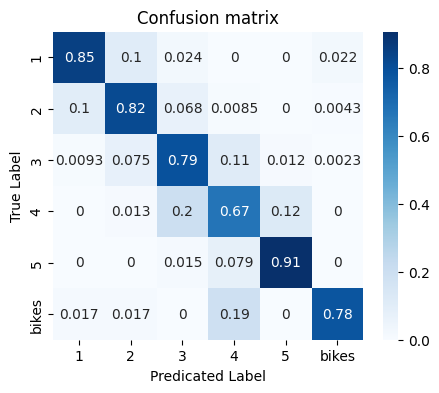

In [23]:
SHAPE_LABELS = [1,2,3,4,5,"bikes"]
total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
total_y_true = [true_label.item() for true_label in total_y_true_label]
cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) 

df_cm = pd.DataFrame(cm, index = SHAPE_LABELS,
              columns = SHAPE_LABELS)
plt.figure(figsize = (5,4))
plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
figure = plot.get_figure()
plt.title("Confusion matrix")
plt.ylabel('True Label')
plt.xlabel('Predicated Label')

#### Distribution of the train data

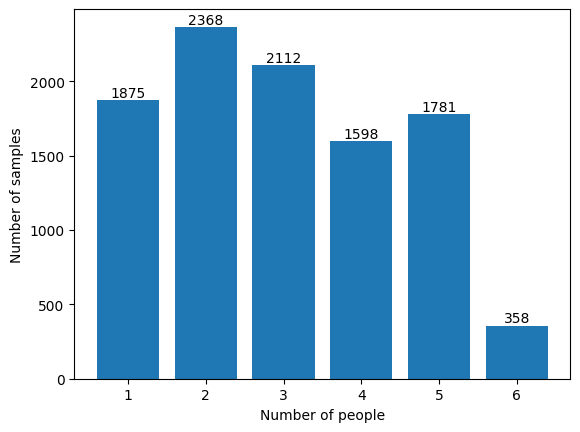

In [11]:
data_points = np.array([d.y.item() for d in train_graphs[0]])
zeros = len(np.where(data_points  == 0)[0])
ones = len(np.where(data_points  == 1)[0])
twos = len(np.where(data_points  == 2)[0])
threes = len(np.where(data_points  == 3)[0]) 
fours = len(np.where(data_points  == 4)[0])
bikes = len(np.where(data_points  == 5)[0])

labels = [1,2,3,4,5, 6]
sample_num = [zeros, ones, twos, threes, fours,bikes]
p = plt.bar(labels, sample_num)
plt.xlabel("Number of people")
plt.ylabel("Number of samples")
plt.bar_label(p)
plt.show()

In [44]:
column_names=['range','azimuth','doppler','snr','x','y','current_frame','seq']
features1 =  [pd.read_csv(filename, names=column_names, header=None, dtype=np.float64) for filename in glob.glob("data/3/3/*.csv")]
fnum_list = [feat["current_frame"][0] for feat in features1]
first = np.array([feat["seq"][0] == 0 for feat in features1])
first = np.where(first)[0]
fnum_list = [fnum_list[i] for i in first]
features1 = [features1[i] for i in first]
fnum = np.array(fnum_list)
print(len(fnum))
unique, counts = np.unique(fnum, return_counts=True)
dict_fnum = dict(zip(unique, counts))
multiple = {k: v for k, v in dict_fnum.items() if v > 1 }
print(len(unique))
print(multiple)
mul = list(multiple.keys())[4]
print(mul)
print(fnum_list.index(mul))
print(fnum_list.index(mul) + fnum_list[fnum_list.index(mul)+1:].index(mul))
identity = [features1[fnum_list.index(mul)], features1[fnum_list.index(mul) + fnum_list[fnum_list.index(mul)+1:].index(mul)+1]]
print(identity)

3879
3747
{85629.0: 2, 85631.0: 2, 85633.0: 2, 85635.0: 2, 85637.0: 2, 85639.0: 2, 85649.0: 2, 85663.0: 2, 85893.0: 2, 85895.0: 2, 85897.0: 2, 85899.0: 2, 85901.0: 2, 85903.0: 2, 86071.0: 2, 86081.0: 2, 86083.0: 2, 86085.0: 2, 86087.0: 2, 86089.0: 2, 86091.0: 2, 86093.0: 2, 86463.0: 2, 86465.0: 2, 86467.0: 2, 86469.0: 2, 86471.0: 2, 110425.0: 2, 110427.0: 2, 110429.0: 2, 110431.0: 2, 110433.0: 2, 110435.0: 2, 110437.0: 2, 110449.0: 2, 110451.0: 2, 110453.0: 2, 110455.0: 2, 110457.0: 2, 110459.0: 2, 110461.0: 2, 110463.0: 2, 110805.0: 2, 110807.0: 2, 110809.0: 2, 110819.0: 2, 110829.0: 2, 110831.0: 2, 110833.0: 2, 110835.0: 2, 110837.0: 2, 110845.0: 2, 110847.0: 2, 111185.0: 2, 111187.0: 2, 111189.0: 2, 111191.0: 2, 111201.0: 2, 111203.0: 2, 111211.0: 2, 111213.0: 2, 111215.0: 2, 111217.0: 2, 111219.0: 2, 111377.0: 2, 111563.0: 2, 111565.0: 2, 111567.0: 2, 111569.0: 2, 111571.0: 2, 111581.0: 2, 111589.0: 2, 111591.0: 2, 111593.0: 2, 111945.0: 2, 111947.0: 2, 111949.0: 2, 111951.0: 2, 11

In [3]:
column_names=['range','azimuth','doppler','snr','x','y','current_frame','seq']
features1 =  [(pd.read_csv(filename, names=column_names, header=None, dtype=np.float64), filename[14:19]) for filename in glob.glob("data/3/3/*.csv")]

In [4]:
from collections import defaultdict
result = defaultdict(list)

for i in range(len(features1)):
    current = features1[i]
    result[current[1]].append(current[0])
            
for k, v in result.items():
    result[k] = pd.concat(v)


print('z')

z


In [5]:
max_frame = -10
for k, v in result.items():
    shift = max_frame+10
    v["current_frame"] += shift
    max_frame = max(v["current_frame"])
    print(max_frame)
print('z')

114171.0
229228.0
333035.0
z


In [6]:
f = pd.concat([v for _, v in result.items()])

In [8]:
print(f.shape)

(1191142, 8)


In [9]:
features3: DataFrame = pd.concat(
        [pd.read_csv(filename, names=column_names, header=None, dtype=np.float64) for filename in glob.glob("data/3/3/*.csv")])
print(features3.shape)

(1191142, 8)


In [11]:
result = defaultdict(list)
print(result)

defaultdict(<class 'list'>, {})


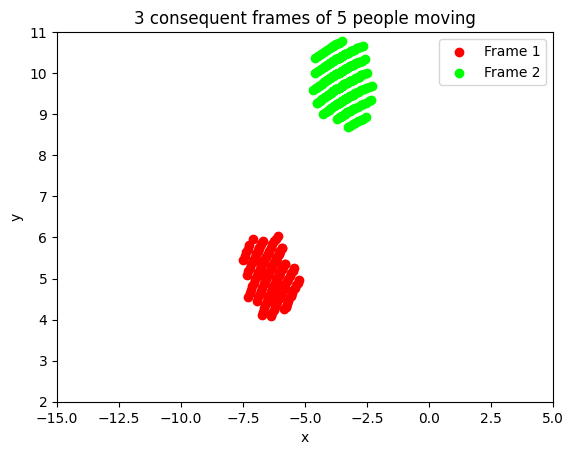

In [43]:
data = [frame.to_numpy() for frame in identity]
frame_num = 0
frame1 = data[frame_num]
frame2 = data[frame_num+1]

plt.scatter(frame1[:, 5], frame1[:, 4], c="red", label="Frame 1")
plt.scatter(frame2[:, 5], frame2[:, 4], c="lime", label="Frame 2")

plt.legend()
plt.title("3 consequent frames of 5 people moving")
plt.ylabel("y")
plt.xlabel("x")
plt.xlim(-15, 5)
plt.ylim(2, 11)
plt.show()